In [1]:
!python -m pip install scikit-learn-intelex

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 64.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 30.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 65.2 MB/s eta 0:00:00:00:0100:01


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import learning_curve

In [4]:
path = "train//keypoints//"
df_train = pd.read_csv(path + "all_keypoints.csv", delimiter=";")
x_train = df_train.iloc[:, 2:].to_numpy()
y_train = df_train["class"]
y_train.to_numpy()

path = "valid//keypoints//"
df_val = pd.read_csv(path + "all_keypoints.csv", delimiter=";")
x_val = df_val.iloc[:, 2:].to_numpy()
y_val = df_val["class"].to_numpy()  # Assuming "class" is your target column

path = "test//keypoints//"
df_test = pd.read_csv(path + "all_keypoints.csv", delimiter=";")
x_test = df_test.iloc[:, 2:].to_numpy()
y_test = df_test["class"].to_numpy()  # Assuming "class" is your target column

x = np.vstack((x_train, x_val))
y = np.hstack((y_train, y_val))

df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'train//keypoints//all_keypoints.csv'

In [9]:
def plot_learning_curve(sizes,train,val):
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    axes.legend(loc="best")
    
    plt.title("Training and Validation Accuracy Curves")
    plt.xlabel('Samples')
    plt.ylabel('Accuracy')
    plt.show()
    return

In [6]:
n_folds = 10 # Max 15 folds
cv = KFold(n_splits=n_folds, shuffle=True, random_state=42)

In [7]:
# create the pipeline:
preprocessing = Pipeline([('pp', Normalizer())])  

# Feature selection, you can also try others
feature_selection = Pipeline([('selectkbest', SelectKBest())])  

classifier = Pipeline([('clf', LogisticRegression(max_iter=100000))])

pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

# You may need to specify other hyperparameters here if you investigate other blocks
k_grid = [1000,1404]
C_grid = [10000]

# And make sure to add them to your param_grid
param_grid = {
    'feature_selection__selectkbest__k' : k_grid,
    'classifier__clf__C' : C_grid,
}

# define GridSearchCV object
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=8, cv=cv, verbose=3, return_train_score=True)

# Train the pipeline
gridsearch.fit(x,y)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('pp', Normalizer())])),
                                       ('feature_selection',
                                        Pipeline(steps=[('selectkbest',
                                                         SelectKBest())])),
                                       ('classifier',
                                        Pipeline(steps=[('clf',
                                                         LogisticRegression(max_iter=100000))]))]),
             n_jobs=8,
             param_grid={'classifier__clf__C': [10000],
                         'feature_selection__selectkbest__k': [1000, 1404]},
             return_train_score=True, verbose=3)

In [8]:
results = gridsearch.cv_results_
train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print('Average training accuracy across folds: {:.3}'.format(train_score))
print('Average validation accuracy across folds: {:.3}'.format(validation_score))

print(gridsearch.best_params_)

Average training accuracy across folds: 0.584
Average validation accuracy across folds: 0.549
{'classifier__clf__C': 10000, 'feature_selection__selectkbest__k': 1000}


In [10]:
best_model = gridsearch.best_estimator_
train_sizes, train_scores, val_scores = learning_curve(best_model, x, y, cv=cv, n_jobs=16, verbose=5)

[learning_curve] Training set sizes: [ 159  518  877 1236 1595]


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   7 out of  50 | elapsed:  1.4min remaining:  8.8min
[Parallel(n_jobs=16)]: Done  18 out of  50 | elapsed:  3.4min remaining:  6.1min
[Parallel(n_jobs=16)]: Done  29 out of  50 | elapsed:  4.8min remaining:  3.5min
[Parallel(n_jobs=16)]: Done  40 out of  50 | elapsed:  6.4min remaining:  1.6min
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:  7.2min finished


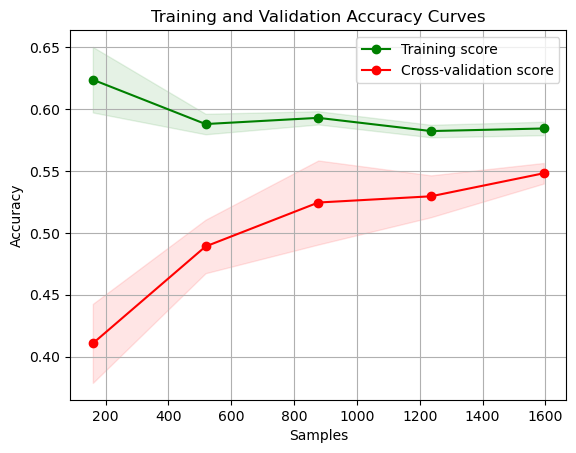

In [11]:
plot_learning_curve(train_sizes, train_scores, val_scores)

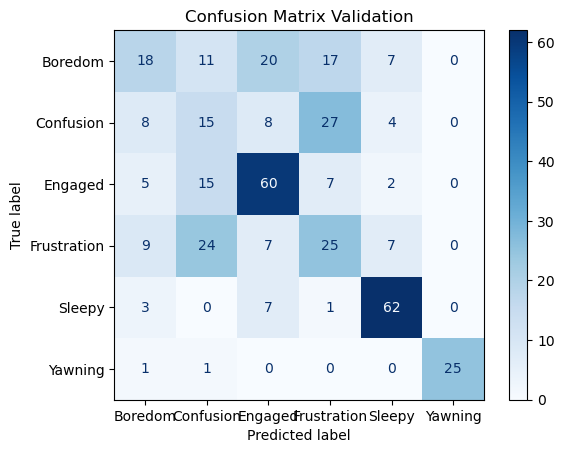

[CV 7/10] END classifier__clf__C=10000, feature_selection__selectkbest__k=1000;, score=(train=0.575, test=0.537) total time= 2.5min
[CV 7/10] END classifier__clf__C=10000, feature_selection__selectkbest__k=1404;, score=(train=0.804, test=0.418) total time= 2.8min
[CV] END ..................., score=(train=0.583, test=0.551) total time= 3.6min
[CV] END ..................., score=(train=0.591, test=0.475) total time= 1.8min
[CV 8/10] END classifier__clf__C=10000, feature_selection__selectkbest__k=1000;, score=(train=0.588, test=0.554) total time= 2.3min
[CV 6/10] END classifier__clf__C=10000, feature_selection__selectkbest__k=1404;, score=(train=0.810, test=0.362) total time= 3.0min
[CV] END ..................., score=(train=0.579, test=0.551) total time= 4.2min
[CV] END ..................., score=(train=0.642, test=0.424) total time=  24.0s
[CV] END ..................., score=(train=0.583, test=0.480) total time= 1.1min
[CV 6/10] END classifier__clf__C=10000, feature_selection__selectkb

In [13]:
# Compute confusion matrix on validation set
best_model.fit(x_train, y_train)
val_predictions = best_model.predict(x_val)
cm = confusion_matrix(y_val, val_predictions)

# Assuming you have class names, replace it with your actual class names or labels
class_names = [str(i) for i in np.unique(y)]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Confusion Matrix Validation")
plt.show()